# Table of Contents
 <p><div class="lev1"><a href="#Imports"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></div><div class="lev1"><a href="#Define-the-model-in-Stan"><span class="toc-item-num">2&nbsp;&nbsp;</span>Define the model in Stan</a></div><div class="lev1"><a href="#Run-the-script-to-do-MCMC-sampling-(using-pyStan)"><span class="toc-item-num">3&nbsp;&nbsp;</span>Run the script to do MCMC sampling (using pyStan)</a></div><div class="lev1"><a href="#Load-the-Cef-file"><span class="toc-item-num">4&nbsp;&nbsp;</span>Load the Cef file</a></div><div class="lev1"><a href="#Load-the-posteriors-and-define-Binary-Patterns"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load the posteriors and define Binary Patterns</a></div><div class="lev1"><a href="#Plot-violins"><span class="toc-item-num">6&nbsp;&nbsp;</span>Plot violins</a></div>

# Imports

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#imports
import pandas as pd
from Cef_tools import *
from itertools import izip
import pystan

# Define the model in Stan


        # Bayesian Negative Binomial regression for single-cell RNA-seq

        data {
            int<lower=0> N;                 # number of outcomes
            int<lower=0> K;                 # number of predictors
            matrix<lower=0>[N,K] x;         # predictor matrix 
            int y[N];                       # outcomes
        }

        parameters {
            vector<lower=1>[K] beta;  # coefficients
            real<lower=0.001> r;  # overdispersion
        }

        model {	
            vector[N] mu;
            vector[N] rv;

            # priors
            r ~ cauchy(0, 1);
            beta ~ pareto(1, 1.5);

            # vectorize the scale
            for (n in 1:N) {
                rv[n] <- square(r + 1) - 1;
            }

            # regression
            mu <- x * (beta - 1) + 0.001;
            y ~ neg_binomial(mu ./ rv, 1 / rv[1]);
        }


# Run the script to do MCMC sampling (using pyStan)

In [ ]:
%run pystan_bayesmodel.py -i data/Mouse_Embryo_nound.cef -o output_folder/ -p 20

# Load the Cef file
This is just reading the annotation, actual data is not used here. Only posteriors will be considered

In [3]:
cef = CEF_obj()
cef.readCEF('data/Mouse_Embryo_nound.cef')

In [4]:
clustering_attribute = 'Cell_type'
for i,v in izip(cef.col_attr_names, cef.col_attr_values):
    if i == clustering_attribute:
        predictor_list = v
    if 'total' in i.lower():
        total_molecules = [float(j) for j in v ]

for i,v in izip(cef.row_attr_names, cef.row_attr_values):
    if 'gene' in i.lower():
        gene_names = v

total = sum(total_molecules)/len(total_molecules)
total_molecules_norm = [j/total for j in total_molecules]
predictors = ['Size']
for i in predictor_list:
    if i not in predictors:
        predictors.append(i)

predictor_matrix = []
for i, c_p in enumerate( predictor_list ):
    predictor_matrix.append( [total_molecules_norm[i]] + [float(c_p==p) for p in predictors[1:]] )

# Load the posteriors and define Binary Patterns

In [5]:
#Load regression filenames and genes names
gene_names = cef.row_attr_values[0]
get_path_from_name = lambda x: 'output_folder/beta_%s.npy' % x
file_paths = map(get_path_from_name, gene_names )

# !!!! For a quick test uncomment the following two lines !!!!!
file_paths = ['output_folder/beta_Th.npy','output_folder/beta_Ednrb.npy']
gene_names = ['Th','Ednrb']

In [6]:
order_predictors = ['Size','mEndo','mPeric', 'mMgl','mEpen', 'mRgl3', 'mRgl2', 'mRgl1',
 'mNProg', 'mNbM', 'mNbML2', 'mNbL2', 'mNbDA', 'mDA0', 'mDA1', 'mDA2',
 'mNbML1', 'mNbML3', 'mNbL1', 'mNbML4', 'mRN', 'mGaba1b', 'mGaba1a', 'mGaba2', 'mSert',
 'mOMTN', 'mNbML5']
reordering = [predictors.index(i) for i in order_predictors ]

In [7]:
x = array(predictor_matrix, dtype=float)
total_relative_to_basal = ( (x>0) * x[:,(array(predictors) == 'Size')] ).sum(0) / (x>0).sum(0)
reordered_total_relative_to_basal = total_relative_to_basal[reordering]

In [8]:
# Define Binary patterns
pattern_dict = {}

for path, gene in zip(file_paths, gene_names):
    d = load(path)[:,reordering] - 1 #because in the mode 1 is added
    
    # Condition 1 to define binary pattern
    difference_basal = d[:,0:1]*reordered_total_relative_to_basal - d + 1e-12
    #Check that the differece with the bassal is positive for almost all the realizations
    bigger_condition = (difference_basal < 0).sum(0) >= 998 # For max strictness do == 1000
    #Check if the gene is "basal"
    bigger_condition[0] = (difference_basal > 0).mean() > 0.999
    
    #Condition 2 to define binary pattern
    median_categories = median(d/reordered_total_relative_to_basal, axis=0)
    median_condition = median_categories >= 0.35 *max(median_categories)
    
    #Condition 3 to define binary pattern
    high_enough = (max(median_categories) > 0.4 )*ones_like(median_condition)
    
    #Logic and: all the condition must be satisfied
    binary_pattern = bigger_condition & median_condition & high_enough
    
    #Store in the dictionary
    pattern_dict[gene] = binary_pattern

In [9]:
median_dict = {}

for path, gene in zip(file_paths, gene_names):
    d = load(path)[:,reordering] - 1 #because in the mode 1 is added

    medians_expression = d[:,0:1]*reordered_total_relative_to_basal + d + 1e-12
    median_dict[gene] = median(medians_expression, 0)

In [10]:
# Make a  pattern dataframe
pattern_df = pd.DataFrame( pattern_dict, index=order_predictors, dtype=int).T
median_df = pd.DataFrame( median_dict, index=order_predictors, dtype=float).T

# Plot violins
of the posterior probability distribution for the NB mean parameters

In [11]:
gene = 'Ednrb' # the name of the gene to plot

In [12]:
from matplotlib.pyplot import violinplot

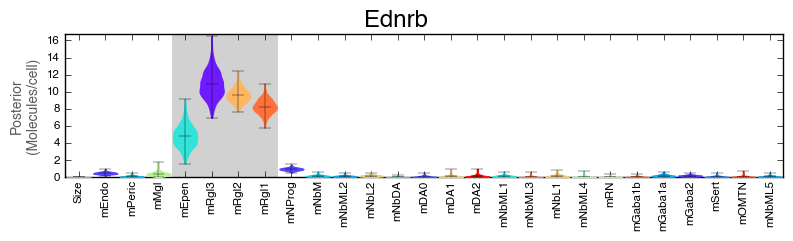

In [13]:
rcParams['savefig.dpi'] = 100


d = load(get_path_from_name(gene))[:,reordering] - 1
binary_pattern = pattern_dict[gene]
maxy = 1.3*percentile(d[:,argmax(d.mean(0))],91.)

fig = figure(figsize=(8,2.5))

r = violinplot(d,widths=0.9, showmeans=True)

for b in r['bodies']:
    b.set_color(cm.rainbow(random.rand()))
    b.set_zorder(100)
    b.set_alpha(1)
for b in [r[u'cbars'],r[u'cmins'],r[u'cmaxes'],r[u'cmeans']]:
    b.set_color('k')
    b.set_alpha(1)
    b.set_linewidth(0.3)
    b.set_zorder(100)

xticks(arange(len(order_predictors))+1, order_predictors, rotation=90)

bar(arange(binary_pattern.size)+1, (2.01*maxy * binary_pattern),color='0.1',\
        width=1 , alpha=0.2, linewidth=0, align='center',zorder=-10)

xticks(rotation=90,horizontalalignment='center', verticalalignment='top',
       position=(0,0.02), fontsize='small')
yticks(fontsize='small')

ylabel('Posterior\n(Molecules/cell)', fontsize='medium', position=(-0.5,0.5), color=(0.2,0.2,0.2), alpha=0.8)
title(gene, position=(0.46,1), fontsize='xx-large')

ylim(0, maxy)

tight_layout()